In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphDiffusionFastGRFKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

Graph size: 10, Probability (GRF): 0.0124, Probability (Diffusion): 0.0085
Graph size: 20, Probability (GRF): 0.0415, Probability (Diffusion): 0.0411
Graph size: 40, Probability (GRF): 0.0291, Probability (Diffusion): 0.0270
Graph size: 80, Probability (GRF): 0.0618, Probability (Diffusion): 0.0596


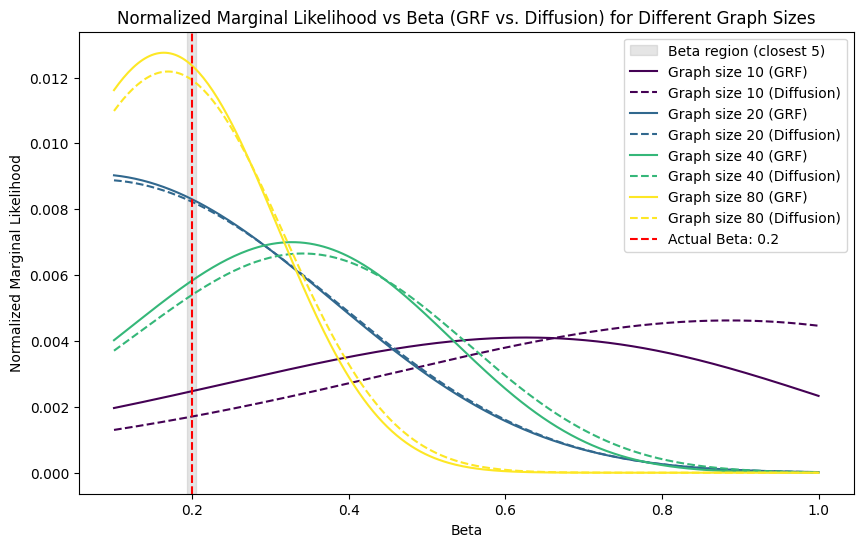

In [4]:
# -- Hyperparameters --
beta_sample = 0.2
noise_std = 0.1
sizes = [10, 20, 40, 80]  # Graph sizes to consider
beta_values = np.linspace(0.1, 1, 300)

def generate_random_graph_by_degree(num_nodes, average_degree):
    probability = average_degree / (num_nodes - 1)  # Calculate edge probability from average degree
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# -- Functions: Evaluate ML using different kernels --
def evaluate_ml_grf(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    # Initialize once so you don't have to re-initialize the kernel each time
    kernel = GraphDiffusionFastGRFKernel(
        adjacency_matrix,
        walks_per_node=1000,
        p_halt=0.1,
        max_walk_length=100,
        beta=0.1  # Placeholder, will be overwritten in the loop
    )
    for beta in beta_values:
        kernel.beta = beta
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

def evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in beta_values:
        kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

# -- Probability calculation near the ground truth --
def calculate_probability_near_truth(ml_values, beta_values, ground_truth, n_samples=5):
    """
    Calculates the fraction of total marginal likelihood in the neighborhood
    of 'ground_truth' by summing the top n_samples closest to ground_truth.
    """
    idx = np.abs(beta_values - ground_truth).argsort()[:n_samples]
    prob_near_truth = np.sum(np.array(ml_values)[idx]) / np.sum(ml_values)
    return prob_near_truth

# ----------------------------------------------------
# Plot Setup
# ----------------------------------------------------
plt.figure(figsize=(10, 6))

# We first find which region of beta_values corresponds to the n=5 points
n_samples = 5
idx_shade = np.abs(beta_values - beta_sample).argsort()[:n_samples]
beta_min_shade, beta_max_shade = beta_values[idx_shade].min(), beta_values[idx_shade].max()

# Optional: use a color map so that each graph size has its own color
colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

# We can shade once, before or after plotting the lines. Usually before is fine:
plt.axvspan(
    beta_min_shade, beta_max_shade,
    color='gray', alpha=0.2,
    label=f'Beta region (closest {n_samples})'
)

for i, num_nodes in enumerate(sizes):
    # 1. Generate graph and adjacency matrix
    adjacency_matrix = generate_random_graph_by_degree(num_nodes, average_degree=10)

    # 2. Generate true kernel and noisy observations
    K_true = diffusion_kernel(adjacency_matrix, beta_sample)
    Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std)
    X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
    Y = tf.convert_to_tensor(Y_noisy, dtype=tf.float64)

    # 3. Compute ML values for GRF kernel
    ml_values_grf = evaluate_ml_grf(adjacency_matrix, X, Y, beta_values, noise_std**2)
    ml_values_grf_normalized = ml_values_grf / np.sum(ml_values_grf)
    probability_grf = calculate_probability_near_truth(
        ml_values_grf, beta_values, beta_sample, n_samples=5
    )

    # 4. Compute ML values for diffusion kernel
    ml_values_diff = evaluate_ml_diffusion(adjacency_matrix, X, Y, beta_values, noise_std**2)
    ml_values_diff_normalized = ml_values_diff / np.sum(ml_values_diff)
    probability_diff = calculate_probability_near_truth(
        ml_values_diff, beta_values, beta_sample, n_samples=5
    )

    # 5. Print probabilities
    print(
        f"Graph size: {num_nodes}, "
        f"Probability (GRF): {probability_grf:.4f}, "
        f"Probability (Diffusion): {probability_diff:.4f}"
    )

    # 6. Plot ML curves on the same axes
    color = colors[i]
    plt.plot(
        beta_values, ml_values_grf_normalized,
        label=f'Graph size {num_nodes} (GRF)',
        color=color, linestyle='-'
    )
    plt.plot(
        beta_values, ml_values_diff_normalized,
        label=f'Graph size {num_nodes} (Diffusion)',
        color=color, linestyle='--'
    )

# -- Vertical line indicating the actual beta --
plt.axvline(x=beta_sample, color='red', linestyle='--', label=f'Actual Beta: {beta_sample}')

# -- Final plot settings --
plt.xlabel('Beta')
plt.ylabel('Normalized Marginal Likelihood')
plt.title('Normalized Marginal Likelihood vs Beta (GRF vs. Diffusion) for Different Graph Sizes')
plt.legend()
plt.show()